## Вариант 1

**Цель:** Контроль дисперсии весов.

- Разработайте архитектуру, которая будет за **5 слоев** приводить тензор к размерности `(1, 512, 1, 1)`.
- **Условие:** дисперсия весов третьего слоя должна быть в **два раза больше**, чем у второго и четвертого.
- **Эксперимент:** Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

---

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter
import numpy as np

import torch
from torch import nn
import torch.nn.init as init

In [2]:
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 3))

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=1, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, padding=1)
        self.relu = nn.ReLU()
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.gap(x)
        return x

In [4]:
def initialize_weights(model, target_var, double_idx=[]):
  """Инициализация весов"""
  idx = -1
  for m in model.modules():
      if isinstance(m, nn.Conv2d):
        std = target_var**0.5
        idx += 1
        if idx in double_idx:
          std = (target_var*2)**0.5
        nn.init.normal_(m.weight, mean=0.0, std=std)
        if m.bias is not None:
            init.constant_(m.bias, 0)

In [5]:
models = [ConvNet(), ConvNet()]

In [6]:
base_var = 0.1 # базовое значение дисперсии
initialize_weights(models[0], base_var)
initialize_weights(models[1], base_var, [2]) # удваивание дисперсии для для 3 слоя

In [7]:
for i, model in enumerate(models):
  var_conv2 = model.conv2.weight.data.var().item()
  var_conv3 = model.conv3.weight.data.var().item()
  var_conv4 = model.conv4.weight.data.var().item()

  print(f'Модель {i+1}')
  print(f'Дисперсия 2 слоя  {var_conv2:.6f}')
  print(f'Дисперсия 3 слоя  {var_conv3:.6f}')
  print(f'Дисперсия 4 слоя  {var_conv4:.6f}')

  print(f'Отношение дисперсий 3 и 2 слоя  {var_conv3/var_conv2:.4f}')
  print(f'Отношение дисперсий 3 и 4 слоя  {var_conv3/var_conv4:.4f}\n')

Модель 1
Дисперсия 2 слоя  0.101007
Дисперсия 3 слоя  0.099849
Дисперсия 4 слоя  0.099968
Отношение дисперсий 3 и 2 слоя  0.9885
Отношение дисперсий 3 и 4 слоя  0.9988

Модель 2
Дисперсия 2 слоя  0.099979
Дисперсия 3 слоя  0.200577
Дисперсия 4 слоя  0.100059
Отношение дисперсий 3 и 2 слоя  2.0062
Отношение дисперсий 3 и 4 слоя  2.0046



In [8]:
test_tensor = torch.randn(1, 3, 32, 32) # Входной размер тензора (1, 3, 32, 32)
results = []
with torch.no_grad():
  for model in models:
    results.append(model(test_tensor))
print(results[0].shape) # Выходной размер (1, 512, 1, 1)

torch.Size([1, 512, 1, 1])


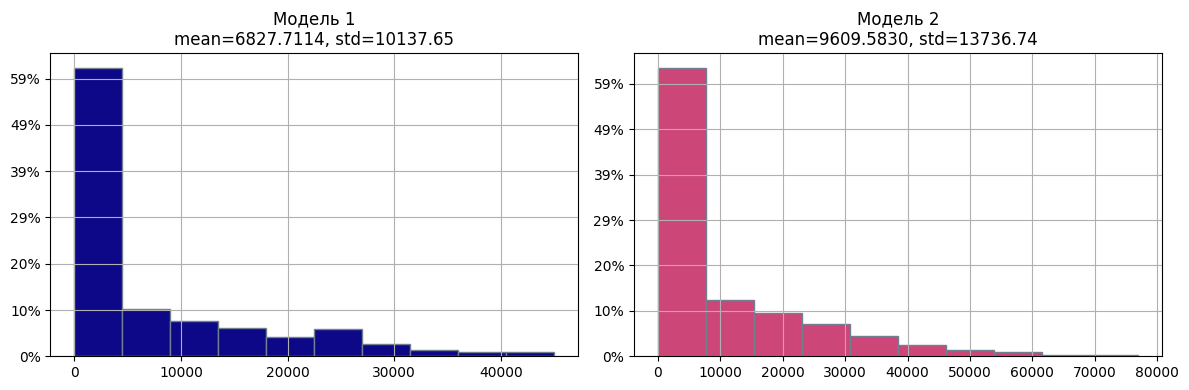

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
for i, res in enumerate(results):
  arr = res.numpy().flatten()
  axs[i].hist(arr, bins=10, color=colors[i], edgecolor="slategrey")
  axs[i].set_title(f'Модель {i+1}\nmean={arr.mean():.4f}, std={arr.std():.2f}')
  axs[i].grid(True)
  axs[i].yaxis.set_major_formatter(PercentFormatter(xmax=512))
plt.show()

**Вывод:**
По построенным гистограммам видно, что в модели с большей дисперсией на 3 слое(Модель 2) среднее значение активаций после GAP выше, чем в случае одинаковой дисперсии, и распределение более широкое.
Также виден длинный правый хвост (т.к. в качестве функции активации использовалась ReLU).

## Вариант 6. Использование разных типов пулинга

**Цель:** Сравнение MaxPool и Global Average Pooling.

- Спроектируйте сеть для входа `(3, 64, 64)` и выхода `(32, 8, 8)`.
- **Условие:** В сети обязательно должны быть **и `MaxPool2d`, и `AdaptiveAvgPool2d`**.
- **Эксперимент:** Сравните выходы после MaxPool и GAP на одном и том же случайном тензоре, визуализируйте карты признаков и среднее значение активаций.

In [146]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x_gap = self.gap(x)
        return x, x_gap

In [147]:
test_tensor = torch.randn(3, 64, 64) # Входной размер тензора (3, 64, 64)
model = Net()
results = {}
with torch.no_grad():
  results["MaxPool"], results["GAP"] = model(test_tensor)
print(results["MaxPool"].shape) # Выходной размер (32, 8, 8)

torch.Size([32, 8, 8])


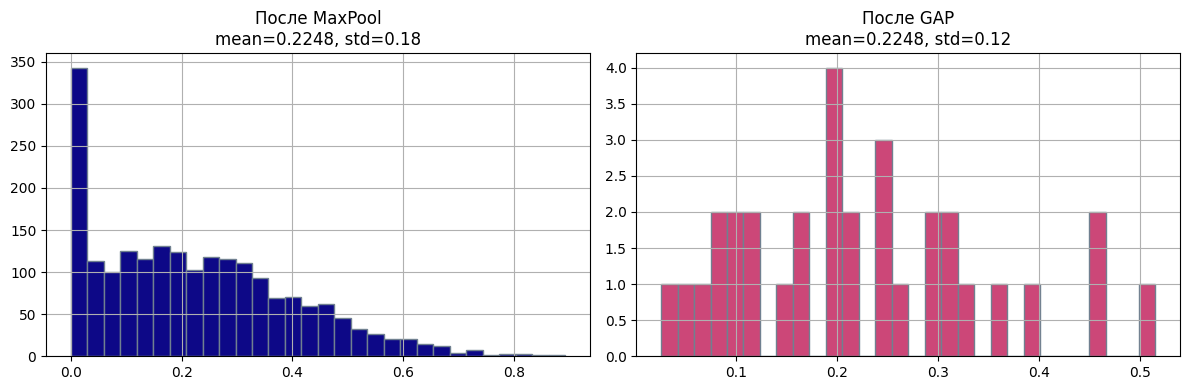

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
for i, (name, res) in enumerate(results.items()):
  arr = res.numpy().flatten()
  axs[i].hist(arr, bins=30, color=colors[i], edgecolor="slategrey")
  axs[i].set_title(f'После {name}\nmean={arr.mean():.4f}, std={arr.std():.2f}')
  axs[i].grid(True)
plt.show()

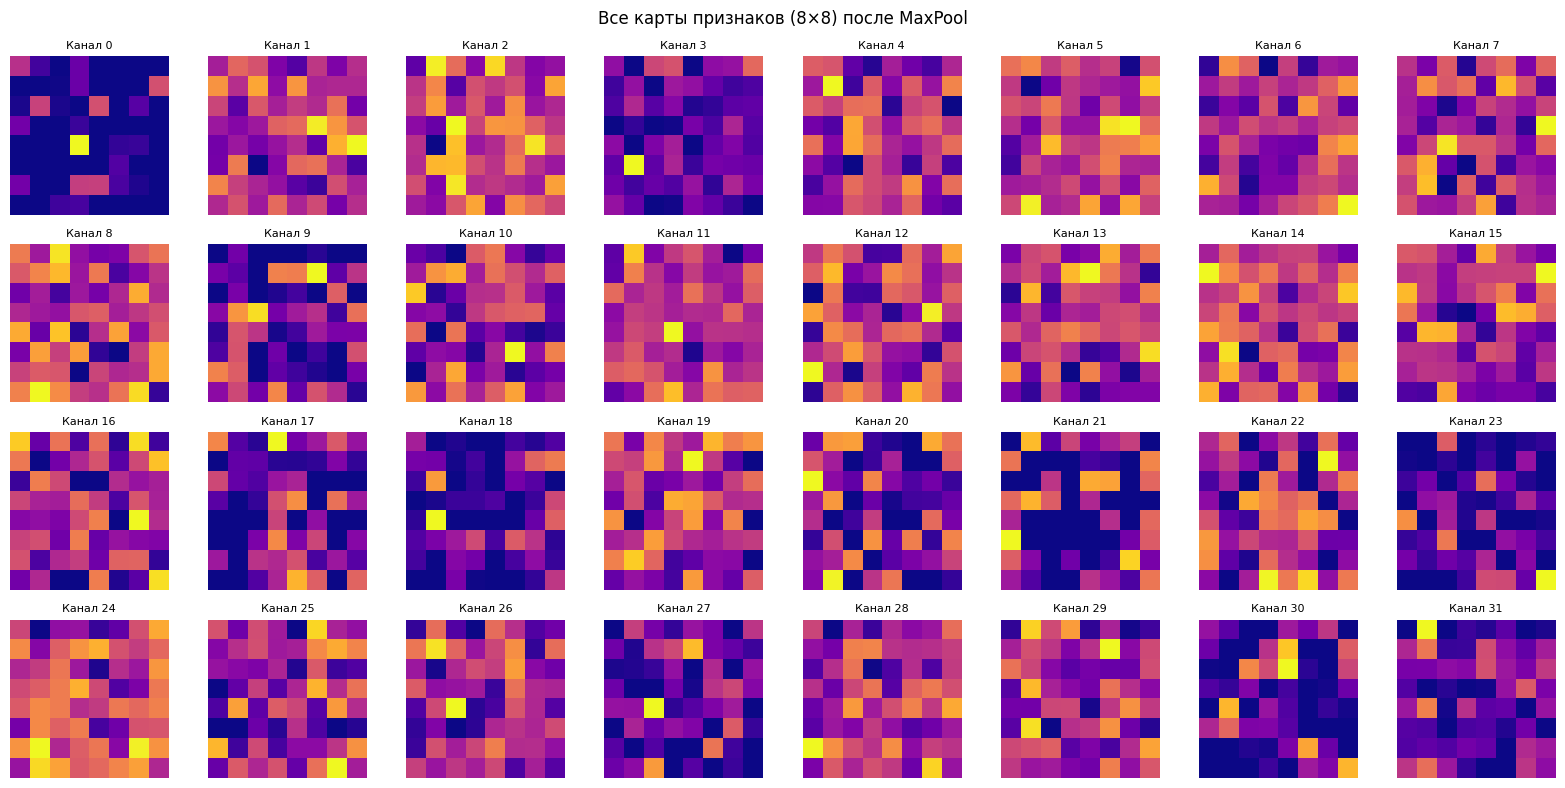

In [135]:
fig, axs = plt.subplots(4, 8, figsize=(16, 8), tight_layout=True)
for i in range(results["MaxPool"].shape[0]):
    axs[i//8, i%8].imshow(results["MaxPool"][i].numpy(), cmap='plasma', interpolation='none')
    axs[i//8, i%8].axis('off')
    axs[i//8, i%8].set_title(f'Канал {i}', fontsize=8)

fig.suptitle('Все карты признаков (8×8) после MaxPool')
plt.show()

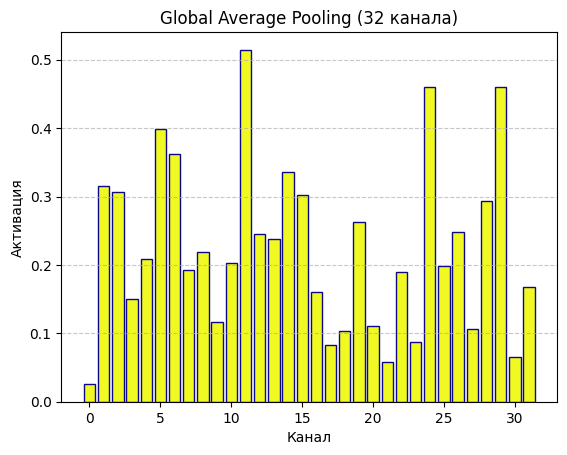

In [136]:
plt.bar(range(32), results["GAP"].flatten().numpy(), color=colors[-1], edgecolor=colors[0])
plt.xlabel('Канал')
plt.ylabel('Активация')
plt.title('Global Average Pooling (32 канала)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Вывод:**
После применения Global Average Pooling дисперсия активаций снижается, а распределение становится более узким. В то время как MaxPool сохраняет информацию о местоположении наиболее выраженных признаков, GAP отбрасывает пространственную структуру, оставляя лишь усреднённую по карте силу отклика каждого канала.
